# Quantify the Error in the Minimum-Energy Structures

### Recipe:

**QCore Minimum-energy cell**
* Find minimum-energy QCore structure from E-V curves
* Extract lattice parameters
* Run these with QE (no structure relaxation)

**QE Minimum-energy cell**
* Run structure relaxation on the Materials Project equilibrium structure
* Look at the difference in total energy per atom for the two structures, computed with DFT\



In [1]:
from __future__ import annotations
%load_ext autoreload
from pathlib import Path
RESULTS_ROOT = Path.cwd().parent.absolute() / 'tb_results'
RESULTS_ROOT

PosixPath('/Users/alexanderbuccheri/Codes/tb_benchmarking/tb_results')

In [2]:
"""Constants
"""
# From https://docs.scipy.org/doc/scipy/reference/constants.html
ry_to_ev = 13.605693122994

# Map file name to the internal material labelling we use....
# Because Alex was stupid, and the file names don't all match the materials labels we use internally :s
inconsistent_name_map = {'bn_cubic': 'bn_cubic', 'bn_hex': 'bn_hex', 'cdse': 'cdse', 'diamond': 'diamond', 'gaas': 'gaas', 'gan': 'gan',
                         'ge': 'germanium', 'graphite': 'graphite', 'mgo': 'mgo', 'mos2': 'mos2', 'nacl': 'nacl', 'pbs': 'pbs',
                         'si': 'silicon', 'tio2_ana': 'tio2_ana', 'tio2_rutile': 'tio2_rutile', 'ws2': 'ws2',
                         'zno': 'zinc_oxide', 'zro2': 'zro2', 'wo3_monoclinic': 'wo3_monoclinic'}


# Execute Espresso on front-end of cluster
qe_run_script = """
#!/bin/bash

# Execute espresso runs using MPI
# Note, qe conda env (may) need to be active
# Execute this like: nohup ./run.sh > terminal.out &

module load mpich-3.3.2/mpich-3.3.2-gcc-9.4.0
module load mkl/latest

# "tio2_ana" removed because the CIF is clearly junk no where near DFT-relaxed
directories=("bn_cubic" "cdse" "gaas" "germanium" "mgo" "nacl" "silicon" "tio2_rutile" "ws2" "zro2" "bn_hex" "diamond" "gan" "graphite" "mos2" "pbs" "wo3_monoc
linic" "zinc_oxide")


for dir in "${directories[@]}"; do
    cd "$dir"
    echo "Running in ${dir}"
    mpirun -np 4 ~/packages/espresso7/bin/pw.x -in espresso.pwi > espresso.pwo
    cd ../
done
"""

# Total energy extraction with bash

# directories=("bn_cubic" "cdse" "gaas" "germanium" "mgo" "nacl" "silicon" "tio2_rutile" "ws2" "zro2"
# "bn_hex" "diamond" "gan" "graphite" "mos2" "pbs" "wo3_monoclinic" "zinc_oxide")
# 
# for dir in "${directories[@]}"; do
#     echo -n "$dir: "; grep -r '!    total energy              =' "$dir/espresso.pwo"
# done


In [4]:
%autoreload 2
""" QCore Minimum-energy cell.

Inputs to compute DFT energy using the QCore-optimised volume and positions.

Optimal (lowest-energy) QCore structure is found by evaluating the E vs V curve.
Atomic positions are neither relaxed in the QCore E vs V calculation, nor in the
DFT calculation using the QCore minimum-energy lattice.
"""
import copy
from pathlib import Path
import re
from typing import Callable

from min_modules.cell_prep import min_energy_cell, qe_cell_string, qe_atomic_positions_string
from nb_modules.qcore_loaders import load_json_qcore


# Not computed or SCF won't converge with QE
missing_from_qe = ['cu', 'pbte', 'wo3_monoclinic', 'tio2_ana']

# List of suboptimal fits and fall back to discrete data (found by inspecting plots)
use_discrete = ['gaas', 'zro2', 'wo3_monoclinic']

materials = ['bn_cubic', 'bn_hex', 'cdse', 'diamond', 'gaas', 'gan', 'ge', 'graphite', 'mgo', 'mos2',
             'nacl', 'pbs', 'si', 'tio2_rutile', 'ws2', 'zno', 'zro2', 'wo3_monoclinic']

# QCore optimal cutoffs
default_optimal_cutoffs = {
                  'bn_cubic': '40',
                  'bn_hex': '40',
                  'cdse': '40',
                  'diamond': '40',
                  'gaas': '40',
                  'gan': '40',
                  'germanium': '40',
                  'graphite': '40',
                  'mgo': '40',
                  'mos2': '40',
                  'nacl': '20',
                  'pbs': '40',
                  'silicon': '40',
                  'tio2_rutile': '20',
                  'ws2': '40',
                  'wo3_monoclinic': '40',
                  'zinc_oxide': '40',
                  'zro2': '40'}


create_new_inputs = False

if create_new_inputs:

    # Copied from QE calculation inputs for the same materials.
    # This is fine, as we're using all the same settings but changing the cell vectors
    # to be consistent with QCore's min-energy structures.
    # (and we assume the change is not sufficient to warrant changing k-grid).
    input_root = Path('input_replacements/source')

    # These have to be SCP'ed back the cluster and placed in relevant work directories.
    output_root = Path('input_replacements/replacements')

    print(f'Creating new inputs QE, using QCore minimum-energy cells in {output_root.as_posix()}')

    # Parse E vs V JSON data
    qcore_results = load_json_qcore(RESULTS_ROOT, "qcore/bulk_system_at_renormalized_cutoff.json", 
                                    default_optimal_cutoffs, output='EVCurveData')
    
    # Compute lattice vectors of each system that give volume = V_qcore
    atoms_list = {}
    for material in materials:
        qcore_atoms = min_energy_cell(qcore_results, material, use_discrete)
        atoms_list[material] = copy.deepcopy(qcore_atoms)
        # print(material)
        # print(qcore_atoms.get_cell_lengths_and_angles())
        # print(qcore_atoms.get_positions(wrap=True))
        # print(qcore_atoms.get_scaled_positions())

    # Espresso input files
    for material in materials:
        renamed_material = inconsistent_name_map[material]

        # Get reference input
        with open(Path(input_root, f'espresso.pwi_{renamed_material}'), 'r') as fid:
            input_text = fid.read()

        # Define new cell vectors and atomic positions
        atoms = atoms_list[material]
        new_cell_str = qe_cell_string(atoms) + '\n' + qe_atomic_positions_string(atoms)
        output_text = re.sub(r'CELL_PARAMETERS.*$', new_cell_str, input_text, flags=re.DOTALL)

        # Output new file
        Path(output_root, renamed_material).mkdir()
        # Previous output: output_root / f'espresso.pwi_{renamed_material}'
        f_name = output_root / renamed_material / 'espresso.pwi'
        print(f'Writing file {f_name} for {material}')
        f_name.write_text(output_text)

    with open(Path(output_root, 'run.sh'), 'w+') as fid:
        input_text = fid.write(qe_run_script)

else:
    print('Not re-generating QE inputs')


Not re-generating QE inputs


/Users/alexanderbuccheri/Codes/tb_benchmarking/.venv/lib/python3.11/site-packages/pymatgen/io/cif.py:1224: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [4]:
""" QE Relaxation Input

Structures *should* be relaxed MP structures, however those calculations are performed with VASP.

Therefore:

1 Take equilibrium input and structures (folder 5 from [0:10]) from E vs V calcs.
  - should have converged k-grids from the SCF study (see that folder)

```bash
cd /users/sol/abuccheri/packages/tb_benchmarking/outputs/espresso_e_vs_v
names=("bn_hex" "cdse" "diamond" "gaas" "gan" "germanium" "graphite" "mgo" "mos2" "nacl" "pbs" "tio2_ana" "tio2_rutile" "ws2" "zinc_oxide" "zro2")
for name in "${names[@]}"; do cp -r "$name/5/" "../espresso_relaxation_bulk/${name}_eq"; done
```
 Note, some materials may be missing from the list above.

2 Add position and cell relaxation options to the input

Change:   calculation      = 'scf'
to:       calculation      = 'vc-relax'

After line match with `pseudo_dir`
add:
   etot_conv_thr = 1e-5
   forc_conv_thr = 1e-4

After &CELL, add
   cell_dofree='ibrav'

This is achieved using 'min_modules.cell_relaxation' and should be run on the machine
where the calculations will take place (or at least where the reference input files are).

3. Note, in some cases run 5 is not the equilibrium/lowest-energy structure.
   However, relaxing something close to the lowest-energy structure should be sufficient.
"""


example_si_relaxation = """
&CONTROL
   calculation      = 'vc-relax'
   prefix           = 'silicon_PBESOL'
   pseudo_dir       = '/users/sol/abuccheri/rutgers_pseudos/pbesol'
   etot_conv_thr = 1e-5
   forc_conv_thr = 1e-4
/
&SYSTEM
   ecutwfc          = 120.0
   ntyp             = 1
   nat              = 2
   ibrav            = 0
/
&ELECTRONS
   conv_thr         = 1e-06
/
&IONS
/
&CELL
   cell_dofree='ibrav'
/

"""


In [5]:
""" Fit the E vs V for QE, and find the lowest total-energy associated with it.

Generates the dictionary given in the next cell(s), with results in Ry.
"""
import numpy as np

from delta_factor.fit_eos import fit_birch_murnaghan_relation, parse_birch_murnaghan_relation
from delta_factor.loader import qe_loader


evaluate_cell = True

if evaluate_cell:
    qe_results = qe_loader(RESULTS_ROOT, materials)

    materials = ['bn_cubic', 'bn_hex', 'cdse', 'diamond', 'gaas', 'gan', 'ge', 'graphite', 'mgo', 'mos2',
                 'nacl', 'pbs', 'si', 'tio2_rutile', 'ws2', 'zno', 'zro2', 'wo3_monoclinic']

    missing_from_qe = ['cu', 'pbte', 'wo3_monoclinic', 'tio2_ana']

    # List of suboptimal fits where one should fall back to discrete data
    use_discrete = ['gaas', 'zro2', 'wo3_monoclinic']

    print('qe_from_e_vs_v = {')
    for material in materials:
        # For suboptimal fits, fall back to discrete data
        if material in use_discrete:
            qe_lowest_energy = np.amin(qe_results[material][:, 1])

        else:
            # Minimum volume found from model fit. More precise than using the discrete data
            fit_data: dict = fit_birch_murnaghan_relation(qe_results[material][:, 0], qe_results[material][:, 1])
            energy_model: Callable = parse_birch_murnaghan_relation(fit_data)
            linearly_sampled_volume = np.linspace(qe_results[material][0, 0], qe_results[material][-1, 0], 100)
            energy_fit = energy_model(linearly_sampled_volume)
            qe_lowest_energy = np.amin(energy_fit)

        print(f" '{material}' : {qe_lowest_energy / ry_to_ev},")
    print('}')
else:
    print('Cell not evaluated')


qe_from_e_vs_v = {
 'bn_cubic' : -26.649224995424213,
 'bn_hex' : -53.224144542857054,
 'cdse' : -315.7604512575075,
 'diamond' : -22.948603780471135,
 'gaas' : -455.0259368148085,
 'gan' : -435.17388088738414,
 'ge' : -426.3833089794724,
 'graphite' : -45.903144540406636,
 'mgo' : -157.6069389439272,
 'mos2' : -375.1503649801772,
 'nacl' : -128.63320738112756,
 'pbs' : -187.98075796208047,
 'si' : -19.12003135210618,
 'tio2_rutile' : -367.9922946998694,
 'ws2' : -414.5328018480476,
 'zno' : -987.0821463870124,
 'zro2' : -164.06265707797093,
 'wo3_monoclinic' : -1023.7099062469316,
}


In [6]:
""" Tabulated Data
"""
from typing import Union

n_atoms = {
'bn_cubic': 2,
'cdse': 4,
'gaas': 2,
'germanium': 2,
'mgo': 2,
'nacl': 2,
'silicon': 2,
'tio2_rutile': 6,
'ws2': 6,
'zro2': 3,
'bn_hex': 4,
'diamond': 2,
'gan': 2,
'graphite': 4,
'mos2': 6,
'pbs': 2,
'wo3_monoclinic': 16,
'zinc_oxide': 4
}


# Minimum-energy QCore structure computed with QE (in Ry)
# Inputs generated with `QCore Minimum-energy cell` above
# See: /users/sol/abuccheri/packages/tb_benchmarking/outputs/espresso_qcore_min
q_core_with_qe = {
'bn_cubic': -26.64921934,  
'cdse': -315.75733481,
'gaas': -455.02323653,
'germanium': -426.38034459,
'mgo': -157.59742385,
'nacl': -128.63213321,
'silicon': -19.11329795,
'tio2_rutile': -367.99171145,
'ws2': -414.53217345,
'zro2': -164.02693106,
'bn_hex': -53.22415132,
'diamond': -22.94852801,
'gan': -435.16028607,
'graphite': -45.90310221,
'mos2': -375.14093191,
'pbs': -187.97875185,
'wo3_monoclinic': -1023.70999638,
'zinc_oxide': -987.05325371 
}

# Minimum-energy  QE cells, found from E vs V analysis
# Does not rely on cell relaxation. Atomic positions are not relaxed
# Computed with the cell above ` Fit the E vs V for QE...`
qe_from_e_vs_v = {
'bn_cubic' : -26.649224995424213,
'bn_hex' : -53.224144542857054,
'cdse' : -315.7604512575075,
'diamond' : -22.948603780471135,
'gaas' : -455.0259368148085,
'gan' : -435.17388088738414,
'germanium' : -426.3833089794724,
'graphite' : -45.903144540406636,
'mgo' : -157.6069389439272,
'mos2' : -375.1503649801772,
'nacl' : -128.63320738112756,
'pbs' : -187.98075796208047,
'silicon' : -19.12003135210618,
'tio2_rutile' : -367.9922946998694,
'ws2' : -414.5328018480476,
'zinc_oxide' : -987.0821463870124,
'zro2' : -164.06265707797093,
'wo3_monoclinic' : -1023.7099062469316
}

# TODO(Alex) Note, that the final total energy is not necessarily the lowest
# - The stress also is not necessarily the lowest for the final iteration
# That suggests these results should not be used, and one should reference to 
# `qe_from_e_vs_v`, where cell relaxation has not been performed by the code.

# /users/sol/abuccheri/packages/tb_benchmarking/outputs/espresso_relaxation_bulk
# In each case, take the cell from the CIF (run dir 5/) and do a relaxation step
# N/A means that the calculation failed

qe_relaxation = {
'bn_cubic': -26.64923665,
'cdse': -315.76049097,
'gaas': -455.02598178,
'germanium': -426.38335113,
'mgo': -157.60695631,         # Forces look converged
'nacl': -128.63321649,
'silicon': -19.12006276,
'tio2_rutile': -367.99292632,
'ws2': -414.53533781,
'zro2': -164.06282477,        # More or less converged
'bn_hex':  'N/A',             # This was clearly not converged -53.29018430,
'diamond': -22.94862192,
'gan':  'N/A',                # Check - looks like it died
'graphite': -45.90360087,
'mos2': 'N/A',                # Check - looks like it died
'pbs': -187.98079462,
'wo3_monoclinic': 'N/A',      # Had to kill it - was taking forever
'zinc_oxide': -987.08224474   # Not converged
}


def compute_error_per_atom(result_a: dict,  result_b: dict, materials: Union[list, set]) -> dict:
    """
    Error per atom, in meV
    """
    error = {}
    for key in materials:
        try:
            error[key] = abs(result_a[key] - result_b[key]) * ry_to_ev * 1000 / float(n_atoms[key])
        except TypeError:
            print(f'Entry missing for {key}')
    return error


def mean_abs_error_per_atom(error: dict) -> float:
    """
    MAE per atom, in meV
    """
    return  sum([e for e in error.values()]) / float(len(error))


In [7]:
""" QCore minimum-energy structure vs QE minimum-energy structure
* Both found from E vs V!
* So no relaxation with QE
"""

all_materials = [
    'bn_cubic',
    'bn_hex',
    'cdse',
    'diamond',
    'gaas',
    'gan',
    'germanium',
    'graphite',
    'mgo',
    'mos2',
    'nacl',
    'pbs',
    'silicon',
    'tio2_rutile',
    'ws2',
    'zinc_oxide',
    'zro2',
    'wo3_monoclinic'
]

# Report the errors and MAE
error = compute_error_per_atom(q_core_with_qe, qe_from_e_vs_v, all_materials)

for key, value in error.items():
    print(key, value , '(meV / atom)')

MAE = mean_abs_error_per_atom(error)

print('MAE for all systems, when comparing QCore minimum-energy structure vs QE minimum-energy structure '
      ', both found via E vs V analysis, and both total-energies computed with QE')
print(MAE, '(meV / atom)')

print('If one pops the oxides: [mgo, zinc_oxide, zro2], improvement really jumps')

error_exclude_ionic = compute_error_per_atom(q_core_with_qe, qe_from_e_vs_v, set(all_materials) - {'mgo', 'zinc_oxide', 'zro2'})
MAE_exclude_ionic = mean_abs_error_per_atom(error_exclude_ionic)
print(MAE_exclude_ionic, '(meV / atom)')



bn_cubic 0.038472983169840776 (meV / atom)
bn_hex 0.023051931782728213 (meV / atom)
cdse 10.600357105319146 (meV / atom)
diamond 0.5154548890218197 (meV / atom)
gaas 18.36962322455048 (meV / atom)
gan 92.4834566960111 (meV / atom)
germanium 20.166286729420914 (meV / atom)
graphite 0.14398363061499106 (meV / atom)
mgo 64.72972400482065 (meV / atom)
mos2 21.390576339731837 (meV / atom)
nacl 7.307421361551655 (meV / atom)
pbs 13.647272668572507 (meV / atom)
silicon 45.80630136521541 (meV / atom)
tio2_rutile 1.322586456068811 (meV / atom)
ws2 1.4249651657468816 (meV / atom)
zinc_oxide 98.27622423286098 (meV / atom)
zro2 162.02574567294968 (meV / atom)
wo3_monoclinic 0.07664517930299854 (meV / atom)
MAE for all systems, when comparing QCore minimum-energy structure vs QE minimum-energy structure , both found via E vs V analysis, and both total-energies computed with QE
31.019341646484023 (meV / atom)
If one pops the oxides: [mgo, zinc_oxide, zro2], improvement really jumps
15.55443038173874

In [8]:
""" QCore minimum-energy structure vs QE minimum-energy structure
* QCore found from E vs V, whereas QE is relaxed for forces and stresses
"""
all_materials = [
    'bn_cubic',
    'bn_hex',
    'cdse',
    'diamond',
    'gaas',
    'gan',
    'germanium',
    'graphite',
    'mgo',
    'mos2',
    'nacl',
    'pbs',
    'silicon',
    'tio2_rutile',
    'ws2',
    'zinc_oxide',
    'zro2',
    'wo3_monoclinic'
]

error_relax = compute_error_per_atom(q_core_with_qe, qe_relaxation, all_materials)

for key, value in error.items():
    print(key, value , '(meV / atom)')

MAE_relax = mean_abs_error_per_atom(error_relax)

print('MAE for all systems')
print(MAE_relax, '(meV / atom)')

print('If one pops the oxides: [mgo, zinc_oxide, zro2], improvement really jumps')
error_exc_ionic_relax = compute_error_per_atom(q_core_with_qe, qe_relaxation, set(all_materials) - {'mgo', 'zinc_oxide', 'zro2'})
MAE_exc_ionic_relax = mean_abs_error_per_atom(error_exc_ionic_relax)
print(MAE_exc_ionic_relax, '(meV / atom)')


Entry missing for bn_hex
Entry missing for gan
Entry missing for mos2
Entry missing for wo3_monoclinic
bn_cubic 0.038472983169840776 (meV / atom)
bn_hex 0.023051931782728213 (meV / atom)
cdse 10.600357105319146 (meV / atom)
diamond 0.5154548890218197 (meV / atom)
gaas 18.36962322455048 (meV / atom)
gan 92.4834566960111 (meV / atom)
germanium 20.166286729420914 (meV / atom)
graphite 0.14398363061499106 (meV / atom)
mgo 64.72972400482065 (meV / atom)
mos2 21.390576339731837 (meV / atom)
nacl 7.307421361551655 (meV / atom)
pbs 13.647272668572507 (meV / atom)
silicon 45.80630136521541 (meV / atom)
tio2_rutile 1.322586456068811 (meV / atom)
ws2 1.4249651657468816 (meV / atom)
zinc_oxide 98.27622423286098 (meV / atom)
zro2 162.02574567294968 (meV / atom)
wo3_monoclinic 0.07664517930299854 (meV / atom)
MAE for all systems
32.55557535619625 (meV / atom)
If one pops the oxides: [mgo, zinc_oxide, zro2], improvement really jumps
Entry missing for gan
Entry missing for wo3_monoclinic
Entry missing

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


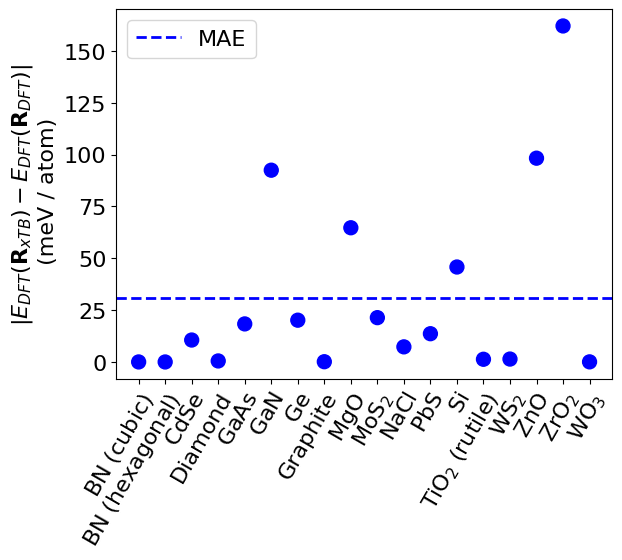

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the errors as a scatter plot, horizontal line at 0 meV/Atom and dashed line for the MAE
label_to_title = {'ws2': '$\mathregular{WS_2}$',
                  'mos2': '$\mathregular{MoS_2}$',
                  'gan': '$\mathregular{GaN}$',
                  'tio2_rutile': '$\mathregular{TiO_2}$ (rutile)',
                  'graphite': 'Graphite',
                  'tio2_ana': '$\mathregular{TiO_2}$ (anatase)',
                  'diamond': 'Diamond',
                  'pbs': '$\mathregular{PbS}$',
                  'germanium': '$\mathregular{Ge}$',
                  'nacl': '$\mathregular{NaCl}$',
                  'zinc_oxide': '$\mathregular{ZnO}$',
                  'gaas': '$\mathregular{GaAs}$',
                  'mgo': '$\mathregular{MgO}$',
                  'silicon': '$\mathregular{Si}$',
                  'cdse': '$\mathregular{CdSe}$',
                  'bn_hex': '$\mathregular{BN}$ (hexagonal)',
                  'bn_cubic': '$\mathregular{BN}$ (cubic)',
                  'zro2': '$\mathregular{ZrO_2}$',
                  'wo3_monoclinic': '$\mathregular{WO_3}$'
                  }

# Reset all figure and plot settings to default, as I appear to now be getting a grid background
plt.rcdefaults()

# plt.subplots_adjust(wspace=0.75)
fig, ax = plt.subplots(1,1) 

# x-axis labels
x_ticks_labels = [label_to_title[m] for m in all_materials]
spacing = 2
x = np.arange(0, len(x_ticks_labels) * spacing, spacing)

# Points
colours = ['blue'] * len(all_materials)

# Horizontal line
plt.axhline(y=MAE, color='blue', linestyle='--', linewidth=2, label='MAE')

# Add labels and legend
# plt.title('Error in DFT Total Energies using QCore and QE \nMinimum-Energy Structures', fontsize=14)
# plt.xlabel('System')
plt.ylabel('$|E_{DFT}(\mathbf{R}_{xTB}) - E_{DFT}(\mathbf{R}_{DFT})|$\n (meV / atom)', fontsize=16)
plt.legend(prop={'size': 16})


distinguish_outliers = False

if distinguish_outliers:
    # Change colour of the oxide outliers systems
    for i in [8, 15, 16]:
        colours[i] = 'red'
    plt.axhline(y=MAE_exclude_ionic, color='red', linestyle='--', linewidth=2, label='MAE (excluding oxide outliers)')

ax.scatter(x, [e for e in error.values()], c=colours, s=100)
ax.set_xticks(x)
ax.tick_params(axis='y', which='major', labelsize=16)
ax.set_xticklabels(x_ticks_labels, rotation=60, fontsize=16, rotation_mode='anchor', ha='right')

plt.savefig("bulk_mae.eps", dpi=300, bbox_inches='tight', pad_inches=0.1)